# Imports

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Reshape, Lambda, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2, ResNet50
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont
from ultralytics import YOLO
import yaml
import optuna


2024-03-29 18:44:01.039445: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


# Data Loading and Preprocessing

In [2]:
bbox_df = pd.read_csv('datasets/data/train_solution_bounding_boxes (1).csv')
bbox_df.columns = ['image_name', 'x_min', 'y_min', 'x_max', 'y_max']

In [188]:
bbox_df

image_name       x_min       y_min       x_max       y_max
0     vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1    vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2    vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3    vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4    vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422
..               ...         ...         ...         ...         ...
554   vid_4_9860.jpg    0.000000  198.321729   49.235251  236.223284
555   vid_4_9880.jpg  329.876184  156.482351  536.664239  250.497895
556   vid_4_9900.jpg    0.000000  168.295823  141.797524  239.176652
557   vid_4_9960.jpg  487.428988  172.233646  616.917699  228.839864
558   vid_4_9980.jpg  221.558631  182.570434  348.585579  238.192196

[559 rows x 5 columns]

In [324]:
def save_annotations_for_yolo(bbox_df, image_dir):
    annotated_images = set()
    
    # Step 1: Create annotations
    for _, row in bbox_df.iterrows():
        image_name = row['image_name']
        image_path = os.path.join(image_dir, image_name)
        image = cv2.imread(image_path)
        ih, iw = image.shape[:2]
        
        x_center = ((row['x_min'] + row['x_max']) / 2) / iw
        y_center = ((row['y_min'] + row['y_max']) / 2) / ih
        box_w = (row['x_max'] - row['x_min']) / iw
        box_h = (row['y_max'] - row['y_min']) / ih
        
        annotation_path = os.path.join(image_dir, os.path.splitext(image_name)[0] + '.txt')
        with open(annotation_path, 'w') as file:
            file.write(f"0 {x_center} {y_center} {box_w} {box_h}\n")  # Assuming class '0' for car
        annotated_images.add(os.path.splitext(image_name)[0])
    
    # Step 2: Delete images without annotations
    for image_file in os.listdir(image_dir):
        if image_file.endswith(('.jpg', '.jpeg', '.png')):
            image_name_without_ext = os.path.splitext(image_file)[0]
            if image_name_without_ext not in annotated_images:
                os.remove(os.path.join(image_dir, image_file))
                print(f"Deleted {image_file} due to missing annotation.")


# Call this function for your training images directory
save_annotations_for_yolo(bbox_df, 'datasets/data/all_images')

Deleted vid_4_2460.jpg due to missing annotation.
Deleted vid_4_10720.jpg due to missing annotation.
Deleted vid_4_14220.jpg due to missing annotation.
Deleted vid_5_30040.jpg due to missing annotation.
Deleted vid_4_25980.jpg due to missing annotation.
Deleted vid_5_27500.jpg due to missing annotation.
Deleted vid_4_7040.jpg due to missing annotation.
Deleted vid_5_28380.jpg due to missing annotation.
Deleted vid_4_19260.jpg due to missing annotation.
Deleted vid_4_5680.jpg due to missing annotation.
Deleted vid_5_26420.jpg due to missing annotation.
Deleted vid_4_21700.jpg due to missing annotation.
Deleted vid_5_31160.jpg due to missing annotation.
Deleted vid_4_29360.jpg due to missing annotation.
Deleted vid_4_11760.jpg due to missing annotation.
Deleted vid_4_3420.jpg due to missing annotation.
Deleted vid_4_7120.jpg due to missing annotation.
Deleted vid_4_19300.jpg due to missing annotation.
Deleted vid_5_29840.jpg due to missing annotation.
Deleted vid_4_9680.jpg due to missin

In [326]:
def split_dataset(image_dir, train_dir, val_dir, val_ratio=0.2):
    # Create train and validation directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # List all image files in the all_images directory
    images = [img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.png'))]
    # Split images into training and validation sets
    train_images, val_images = train_test_split(images, test_size=val_ratio, random_state=42)

    # Function to copy images and their annotations to a new directory
    def copy_files(files, source_dir, target_dir):
        for file in files:
            # Copy image
            shutil.move(os.path.join(source_dir, file), os.path.join(target_dir, file))
            # Copy corresponding annotation file
            annotation_file = os.path.splitext(file)[0] + '.txt'
            shutil.move(os.path.join(source_dir, annotation_file), os.path.join(target_dir, annotation_file))

    # Copy training images and annotations to train_images directory
    copy_files(train_images, image_dir, train_dir)
    # Copy validation images and annotations to val_images directory
    copy_files(val_images, image_dir, val_dir)

    print(f"Training set: {len(train_images)} images")
    print(f"Validation set: {len(val_images)} images")

# Define your directories
all_images_dir = 'datasets/data/all_images'
train_images_dir = 'datasets/data/train_images'
val_images_dir = 'datasets/data/val_images'

# Split the dataset
split_dataset(all_images_dir, train_images_dir, val_images_dir, val_ratio=0.2)

Training set: 284 images
Validation set: 71 images


In [340]:
data_yaml_content = {
    'path': '/Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data', # path to images
    'train': 'train_images', # training images path relative to 'path'
    'val': 'val_images', # validation images path relative to 'path'
    'nc': 1, # number of classes
    'names': ['car'] # class names
}

with open('datasets/data.yaml', 'w') as file:
    yaml.dump(data_yaml_content, file, default_flow_style=False)

# Model

In [4]:
model = YOLO("yolov8s.pt")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


# Training

In [5]:
# Define your custom configuration for training if needed
config = {
    'epochs': 10,  # Number of epochs to train for
    'batch_size': 32,  # Batch size
    'lr': 0.001,  # Learning rate
    'patience': 4,  # Patience for early stopping
}

In [6]:
model.train(
    data='datasets/data.yaml',  # YAML file specifying dataset paths and classes
    imgsz=640,  # Image size
    batch=config['batch_size'],
    epochs=config['epochs'],
    lr0=config['lr'],  # Initial learning rate
    patience=config['patience'],  # Patience for early stopping
)

Ultralytics YOLOv8.1.34 🚀 Python-3.12.0 torch-2.2.0 CPU (Intel Core(TM) i9-9880H 2.30GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=datasets/data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train17, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

train: Scanning /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/train_images.cache... 284 images, 0 backgrounds, 0 corrupt: 100%|██████████| 284/284 [00:00<?, ?it/s]
val: Scanning /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/val_images.cache... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<?, ?it/s]


Plotting labels to runs/detect/train17/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2024/03/26 16:57:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead."
2024/03/26 16:57:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for transformers.
2024/03/26 16:57:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/03/26 16:57:53 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2024/03/26 16:57:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


MLflow: logging run_id(ec3e70cbaf3d4b7f891c6d27f4cde966) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train17
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.713      6.936      1.281         25        640: 100%|██████████| 9/9 [06:41<00:00, 44.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.22s/it]

                   all         71         71      0.641      0.944      0.707      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.316      2.613      1.086         26        640: 100%|██████████| 9/9 [06:43<00:00, 44.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.84s/it]

                   all         71         71      0.282      0.887      0.273      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G        1.3      1.823      1.132         24        640: 100%|██████████| 9/9 [06:18<00:00, 42.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.07s/it]

                   all         71         71      0.047       0.93     0.0474     0.0313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.298      1.521      1.115         22        640: 100%|██████████| 9/9 [06:09<00:00, 41.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.00s/it]

                   all         71         71      0.689      0.998      0.793      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.228      1.294      1.079         25        640: 100%|██████████| 9/9 [06:54<00:00, 46.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.85s/it]

                   all         71         71       0.73      0.901      0.858      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.241      1.104      1.089         24        640: 100%|██████████| 9/9 [07:06<00:00, 47.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.50s/it]

                   all         71         71      0.683      0.845       0.71      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.189      1.012      1.056         25        640: 100%|██████████| 9/9 [06:30<00:00, 43.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.02s/it]

                   all         71         71      0.661      0.796      0.703      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.157     0.9751      1.058         26        640: 100%|██████████| 9/9 [06:28<00:00, 43.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.11s/it]

                   all         71         71      0.679      0.803      0.687      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.178     0.9329      1.087         24        640: 100%|██████████| 9/9 [07:27<00:00, 49.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.26s/it]

                   all         71         71      0.682      0.915      0.793      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.134     0.8821      1.034         25        640: 100%|██████████| 9/9 [06:11<00:00, 41.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.52s/it]

                   all         71         71      0.705      0.887      0.811      0.541



10 epochs completed in 1.149 hours.
Optimizer stripped from runs/detect/train17/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train17/weights/best.pt, 22.5MB

Validating runs/detect/train17/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.0 torch-2.2.0 CPU (Intel Core(TM) i9-9880H 2.30GHz)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.18s/it]


                   all         71         71      0.731      0.901      0.858      0.566
Speed: 2.4ms preprocess, 133.5ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train17
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x16fec5ee0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048,    

In [55]:
def objective(trial):
    # Define the hyperparameters' search space
    lr = trial.suggest_categorical('lr', [1e-5, 1e-4, 1e-3, 1e-2])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    imgsz = trial.suggest_categorical('imgsz', [640, 1280])
    epochs = trial.suggest_int('epochs', 5, 20)
    
    # Train the model with the hyperparameters
    model = YOLO("yolov8s.pt")
    model.train(
        data='datasets/data.yaml',
        imgsz=imgsz,
        batch=batch_size,
        epochs=epochs,
        lr0=lr,
        patience=4,
        project='runs/',
        name=f'{lr}_{batch_size}_{imgsz}_{epochs}'

    )
    
    # Assuming the results.csv is saved in the last training directory
    results_path = f'runs/{lr}_{batch_size}_{imgsz}_{epochs}/results.csv' 
    metrics = pd.read_csv(results_path)

    # Example: Use the last epoch's validation mAP@0.5 as the objective metric
    # Adjust the column name based on the metric you care about
    last_row = metrics.iloc[-1]  # Get the last row of metrics, assuming it corresponds to the last epoch
    objective_metric = last_row['      metrics/recall(B)']  # You can change this to any metric you're interested in
    
    return objective_metric  # Note: Optuna minimizes the objective, so if you're maximizing mAP, return its negative


In [56]:
study = optuna.create_study(direction='maximize')  # We're maximizing mAP
study.optimize(objective, n_trials=10)

print("Number of finished trials:", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("Value (Negative mAP):", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"{key}: {value}")

[I 2024-03-28 18:59:35,314] A new study created in memory with name: no-name-513aacbb-b979-48ba-a255-a838a23a86f8


New https://pypi.org/project/ultralytics/8.1.36 available 😃 Update with 'pip install -U ultralytics'


Python(94556) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ultralytics YOLOv8.1.34 🚀 Python-3.12.0 torch-2.2.0 CPU (Intel Core(TM) i9-9880H 2.30GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=datasets/data.yaml, epochs=9, time=None, patience=4, batch=32, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/, name=0.001_32_1280_9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

train: Scanning /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/train_images.cache... 284 images, 0 backgrounds, 0 corrupt: 100%|██████████| 284/284 [00:00<?, ?it/s]
val: Scanning /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/val_images.cache... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<?, ?it/s]

Plotting labels to runs/0.001_32_1280_9/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2024/03/28 18:59:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for transformers.
2024/03/28 18:59:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/03/28 18:59:42 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2024/03/28 18:59:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


MLflow: logging run_id(4d69877d464b4b7786aaf5ebfe838857) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 0 dataloader workers
Logging results to runs/0.001_32_1280_9
Starting training for 9 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/9         0G      1.756      8.864       1.67         49       1280: 100%|██████████| 9/9 [38:19<00:00, 255.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:51<00:51, 51.34s/it]

WARNING ⚠️ NMS time limit 2.350s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:59<00:00, 29.60s/it]

                   all         71         71      0.658      0.169      0.143      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/9         0G      1.266      3.266      1.271         47       1280: 100%|██████████| 9/9 [33:01<00:00, 220.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:45<00:00, 22.86s/it]

                   all         71         71    0.00294      0.366    0.00264    0.00164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/9         0G      1.217      2.142       1.25         52       1280: 100%|██████████| 9/9 [33:26<00:00, 222.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:50<00:00, 25.08s/it]

                   all         71         71       0.64      0.746      0.574      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/9         0G      1.264      1.465      1.281         54       1280: 100%|██████████| 9/9 [35:38<00:00, 237.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:49<00:00, 24.54s/it]

                   all         71         71      0.641      0.634      0.575       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/9         0G      1.236      1.278      1.279         62       1280: 100%|██████████| 9/9 [38:16<00:00, 255.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:56<00:00, 28.05s/it]

                   all         71         71      0.661       0.66      0.553      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        6/9         0G      1.196      1.157      1.285         43       1280: 100%|██████████| 9/9 [33:45<00:00, 225.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:45<00:00, 22.58s/it]

                   all         71         71      0.576      0.651      0.591      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        7/9         0G      1.129     0.9592      1.226         44       1280: 100%|██████████| 9/9 [27:58<00:00, 186.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:40<00:00, 20.23s/it]

                   all         71         71      0.645      0.831      0.728      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        8/9         0G      1.143     0.8794      1.227         46       1280: 100%|██████████| 9/9 [27:51<00:00, 185.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:40<00:00, 20.02s/it]

                   all         71         71      0.672      0.925      0.792      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        9/9         0G      1.148     0.8781      1.243         48       1280: 100%|██████████| 9/9 [27:40<00:00, 184.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:40<00:00, 20.38s/it]

                   all         71         71      0.716      0.887      0.826      0.565



9 epochs completed in 5.067 hours.
Optimizer stripped from runs/0.001_32_1280_9/weights/last.pt, 22.6MB
Optimizer stripped from runs/0.001_32_1280_9/weights/best.pt, 22.6MB

Validating runs/0.001_32_1280_9/weights/best.pt...


Python(11873) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ultralytics YOLOv8.1.34 🚀 Python-3.12.0 torch-2.2.0 CPU (Intel Core(TM) i9-9880H 2.30GHz)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:35<00:00, 17.54s/it]


                   all         71         71      0.715      0.887      0.825      0.564
Speed: 5.1ms preprocess, 474.5ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/0.001_32_1280_9
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


[I 2024-03-29 00:04:31,693] Trial 0 finished with value: 0.88732 and parameters: {'lr': 0.001, 'batch_size': 32, 'imgsz': 1280, 'epochs': 9}. Best is trial 0 with value: 0.88732.


New https://pypi.org/project/ultralytics/8.1.36 available 😃 Update with 'pip install -U ultralytics'


Python(11912) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ultralytics YOLOv8.1.34 🚀 Python-3.12.0 torch-2.2.0 CPU (Intel Core(TM) i9-9880H 2.30GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=datasets/data.yaml, epochs=13, time=None, patience=4, batch=16, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/, name=0.0001_16_1280_13, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True

train: Scanning /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/train_images.cache... 284 images, 0 backgrounds, 0 corrupt: 100%|██████████| 284/284 [00:00<?, ?it/s]
val: Scanning /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/val_images.cache... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<?, ?it/s]


Plotting labels to runs/0.0001_16_1280_13/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2024/03/29 00:04:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for transformers.
2024/03/29 00:04:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/03/29 00:04:38 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2024/03/29 00:04:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


MLflow: logging run_id(d747a80e93ff4ba7a2e30410302026b2) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 0 dataloader workers
Logging results to runs/0.0001_16_1280_13
Starting training for 13 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/13         0G       1.53      6.156      1.458         19       1280: 100%|██████████| 18/18 [26:14<00:00, 87.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:39<00:00, 13.18s/it]

                   all         71         71      0.163      0.761      0.161      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/13         0G      1.234      2.472      1.283         23       1280: 100%|██████████| 18/18 [26:04<00:00, 86.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:38<00:00, 12.72s/it]

                   all         71         71      0.149      0.296     0.0866     0.0509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/13         0G      1.361       1.69      1.387         24       1280: 100%|██████████| 18/18 [25:52<00:00, 86.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:37<00:00, 12.53s/it]

                   all         71         71       0.61      0.662      0.525       0.32


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/13         0G      1.393       2.18      1.493         11       1280: 100%|██████████| 18/18 [25:30<00:00, 85.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:37<00:00, 12.35s/it]

                   all         71         71      0.636      0.859      0.679      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/13         0G      1.463      1.646      1.569         12       1280: 100%|██████████| 18/18 [24:51<00:00, 82.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:37<00:00, 12.42s/it]

                   all         71         71     0.0743      0.169     0.0542     0.0295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/13         0G      1.416      1.324      1.535         10       1280: 100%|██████████| 18/18 [25:02<00:00, 83.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:42<00:00, 14.02s/it]

                   all         71         71      0.553      0.733       0.57       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/13         0G      1.371      1.281      1.558         12       1280: 100%|██████████| 18/18 [25:52<00:00, 86.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:42<00:00, 14.08s/it]

                   all         71         71      0.135      0.189     0.0897     0.0438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/13         0G      1.357      1.195      1.445          9       1280: 100%|██████████| 18/18 [25:19<00:00, 84.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:38<00:00, 12.98s/it]

                   all         71         71      0.139      0.479      0.129     0.0703
Stopping training early as no improvement observed in last 4 epochs. Best results observed at epoch 4, best model saved as best.pt.
To update EarlyStopping(patience=4) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



8 epochs completed in 3.511 hours.
Optimizer stripped from runs/0.0001_16_1280_13/weights/last.pt, 22.6MB
Optimizer stripped from runs/0.0001_16_1280_13/weights/best.pt, 22.6MB

Validating runs/0.0001_16_1280_13/weights/best.pt...


Python(24887) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ultralytics YOLOv8.1.34 🚀 Python-3.12.0 torch-2.2.0 CPU (Intel Core(TM) i9-9880H 2.30GHz)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:35<00:00, 11.71s/it]


                   all         71         71      0.636      0.859      0.679      0.414
Speed: 6.0ms preprocess, 470.0ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/0.0001_16_1280_13
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


[I 2024-03-29 03:36:05,525] Trial 1 finished with value: 0.47887 and parameters: {'lr': 0.0001, 'batch_size': 16, 'imgsz': 1280, 'epochs': 13}. Best is trial 0 with value: 0.88732.


New https://pypi.org/project/ultralytics/8.1.37 available 😃 Update with 'pip install -U ultralytics'


Python(24930) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ultralytics YOLOv8.1.34 🚀 Python-3.12.0 torch-2.2.0 CPU (Intel Core(TM) i9-9880H 2.30GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=datasets/data.yaml, epochs=7, time=None, patience=4, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/, name=0.001_32_640_7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sho

train: Scanning /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/train_images.cache... 284 images, 0 backgrounds, 0 corrupt: 100%|██████████| 284/284 [00:00<?, ?it/s]
val: Scanning /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/val_images.cache... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<?, ?it/s]

Plotting labels to runs/0.001_32_640_7/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2024/03/29 03:36:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for transformers.
2024/03/29 03:36:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/03/29 03:36:12 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2024/03/29 03:36:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


MLflow: logging run_id(c1d14e4eb6184066abe5466c501ef05c) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/0.001_32_640_7
Starting training for 7 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/7         0G      1.623      3.425      1.247         49        640: 100%|██████████| 9/9 [06:00<00:00, 40.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.26s/it]

                   all         71         71       0.51      0.915      0.554      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/7         0G      1.283      1.838      1.122         47        640: 100%|██████████| 9/9 [06:05<00:00, 40.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.47s/it]

                   all         71         71      0.591      0.958      0.654      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/7         0G      1.236      1.325      1.097         52        640: 100%|██████████| 9/9 [05:33<00:00, 37.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.58s/it]

                   all         71         71      0.591      0.855      0.717      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/7         0G      1.263       1.22      1.104         54        640: 100%|██████████| 9/9 [05:45<00:00, 38.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.33s/it]

                   all         71         71      0.529      0.873      0.663      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/7         0G      1.201     0.9934      1.081         62        640: 100%|██████████| 9/9 [06:03<00:00, 40.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.36s/it]

                   all         71         71       0.64      0.817      0.745      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        6/7         0G      1.181     0.9609      1.095         43        640: 100%|██████████| 9/9 [05:47<00:00, 38.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.34s/it]

                   all         71         71      0.737      0.831      0.855      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        7/7         0G      1.114     0.8603      1.077         44        640: 100%|██████████| 9/9 [05:54<00:00, 39.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.62s/it]

                   all         71         71      0.678      0.949      0.858      0.602



7 epochs completed in 0.715 hours.
Optimizer stripped from runs/0.001_32_640_7/weights/last.pt, 22.5MB
Optimizer stripped from runs/0.001_32_640_7/weights/best.pt, 22.5MB

Validating runs/0.001_32_640_7/weights/best.pt...


Python(27050) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ultralytics YOLOv8.1.34 🚀 Python-3.12.0 torch-2.2.0 CPU (Intel Core(TM) i9-9880H 2.30GHz)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.07s/it]


                   all         71         71      0.677      0.946      0.858      0.602
Speed: 2.2ms preprocess, 132.3ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/0.001_32_640_7
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


[I 2024-03-29 04:19:25,526] Trial 2 finished with value: 0.949 and parameters: {'lr': 0.001, 'batch_size': 32, 'imgsz': 640, 'epochs': 7}. Best is trial 2 with value: 0.949.


New https://pypi.org/project/ultralytics/8.1.37 available 😃 Update with 'pip install -U ultralytics'


Python(27079) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ultralytics YOLOv8.1.34 🚀 Python-3.12.0 torch-2.2.0 CPU (Intel Core(TM) i9-9880H 2.30GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=datasets/data.yaml, epochs=20, time=None, patience=4, batch=16, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/, name=0.0001_16_1280_20, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True

train: Scanning /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/train_images.cache... 284 images, 0 backgrounds, 0 corrupt: 100%|██████████| 284/284 [00:00<?, ?it/s]
val: Scanning /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/val_images.cache... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<?, ?it/s]

Plotting labels to runs/0.0001_16_1280_20/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2024/03/29 04:19:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for transformers.
2024/03/29 04:19:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/03/29 04:19:32 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2024/03/29 04:19:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


MLflow: logging run_id(7eb9a94d9a314fd3a1b7b8c077bdec49) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 0 dataloader workers
Logging results to runs/0.0001_16_1280_20
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G       1.53      6.156      1.458         19       1280: 100%|██████████| 18/18 [25:26<00:00, 84.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:38<00:00, 12.99s/it]

                   all         71         71      0.163      0.761      0.161      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      1.227      2.393       1.28         23       1280: 100%|██████████| 18/18 [25:38<00:00, 85.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:37<00:00, 12.38s/it]

                   all         71         71      0.601      0.577      0.454      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      1.328      1.609      1.367         24       1280: 100%|██████████| 18/18 [25:49<00:00, 86.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:36<00:00, 12.22s/it]

                   all         71         71      0.551      0.746        0.6       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G      1.338       1.44      1.344         30       1280: 100%|██████████| 18/18 [25:56<00:00, 86.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:37<00:00, 12.42s/it]

                   all         71         71    0.00372      0.183    0.00318      0.002



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G      1.319      1.223      1.397         27       1280: 100%|██████████| 18/18 [25:39<00:00, 85.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:36<00:00, 12.32s/it]

                   all         71         71      0.607      0.507      0.469      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G      1.398      1.264      1.449         20       1280: 100%|██████████| 18/18 [25:52<00:00, 86.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:36<00:00, 12.22s/it]

                   all         71         71      0.573      0.416      0.415      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G      1.412      1.164      1.423         21       1280: 100%|██████████| 18/18 [25:45<00:00, 85.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:38<00:00, 12.70s/it]

                   all         71         71      0.666      0.871      0.747      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G      1.339      1.107      1.401         24       1280: 100%|██████████| 18/18 [25:54<00:00, 86.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:42<00:00, 14.15s/it]

                   all         71         71      0.663      0.831       0.67      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G      1.262     0.9824      1.324         24       1280: 100%|██████████| 18/18 [30:03<00:00, 100.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:43<00:00, 14.35s/it]

                   all         71         71      0.723      0.901      0.774      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G      1.291      1.046      1.344         20       1280: 100%|██████████| 18/18 [29:18<00:00, 97.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:42<00:00, 14.25s/it]

                   all         71         71      0.673      0.831      0.697      0.449


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G      1.328      1.045      1.434         12       1280: 100%|██████████| 18/18 [56:30<00:00, 188.34s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:37<00:00, 12.60s/it]

                   all         71         71      0.717      0.958      0.776      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G      1.183      1.042      1.343         11       1280: 100%|██████████| 18/18 [27:18<00:00, 91.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.73s/it]

                   all         71         71      0.692      0.917      0.741      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G      1.275      1.045      1.419         11       1280: 100%|██████████| 18/18 [34:20<00:00, 114.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:52<00:00, 17.39s/it]

                   all         71         71      0.672      0.859      0.714      0.445
Stopping training early as no improvement observed in last 4 epochs. Best results observed at epoch 9, best model saved as best.pt.
To update EarlyStopping(patience=4) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



13 epochs completed in 6.550 hours.
Optimizer stripped from runs/0.0001_16_1280_20/weights/last.pt, 22.6MB
Optimizer stripped from runs/0.0001_16_1280_20/weights/best.pt, 22.6MB

Validating runs/0.0001_16_1280_20/weights/best.pt...


Python(48577) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ultralytics YOLOv8.1.34 🚀 Python-3.12.0 torch-2.2.0 CPU (Intel Core(TM) i9-9880H 2.30GHz)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:47<00:00, 15.83s/it]


                   all         71         71      0.723      0.901      0.773      0.525
Speed: 8.1ms preprocess, 642.9ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/0.0001_16_1280_20
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


[I 2024-03-29 10:53:31,488] Trial 3 finished with value: 0.85915 and parameters: {'lr': 0.0001, 'batch_size': 16, 'imgsz': 1280, 'epochs': 20}. Best is trial 2 with value: 0.949.


New https://pypi.org/project/ultralytics/8.1.37 available 😃 Update with 'pip install -U ultralytics'


Python(48621) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ultralytics YOLOv8.1.34 🚀 Python-3.12.0 torch-2.2.0 CPU (Intel Core(TM) i9-9880H 2.30GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=datasets/data.yaml, epochs=6, time=None, patience=4, batch=32, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/, name=1e-05_32_1280_6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

train: Scanning /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/train_images.cache... 284 images, 0 backgrounds, 0 corrupt: 100%|██████████| 284/284 [00:00<?, ?it/s]
val: Scanning /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/val_images.cache... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<?, ?it/s]


Plotting labels to runs/1e-05_32_1280_6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=1e-05' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2024/03/29 10:53:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for transformers.
2024/03/29 10:53:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/03/29 10:53:46 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2024/03/29 10:53:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


MLflow: logging run_id(448580a11ef84bc5bc51b5d231b3a7e4) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 0 dataloader workers
Logging results to runs/1e-05_32_1280_6
Starting training for 6 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/6         0G      1.756      8.864       1.67         49       1280: 100%|██████████| 9/9 [36:59<00:00, 246.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [01:02<01:02, 62.08s/it]

WARNING ⚠️ NMS time limit 2.350s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [01:09<00:00, 34.64s/it]

                   all         71         71      0.658      0.169      0.143      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/6         0G      1.267      3.242      1.265         47       1280: 100%|██████████| 9/9 [35:57<00:00, 239.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [01:08<00:00, 34.31s/it]

                   all         71         71    0.00419      0.479    0.00352    0.00233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/6         0G      1.217       1.82      1.235         52       1280: 100%|██████████| 9/9 [36:18<00:00, 242.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:59<00:00, 29.58s/it]

                   all         71         71    0.00565      0.493    0.00438    0.00271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/6         0G      1.244      1.372      1.251         54       1280: 100%|██████████| 9/9 [37:15<00:00, 248.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [01:03<00:00, 31.64s/it]

                   all         71         71      0.767      0.465      0.495      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/6         0G      1.188      1.196      1.238         62       1280: 100%|██████████| 9/9 [37:49<00:00, 252.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:58<00:00, 29.41s/it]

                   all         71         71      0.687      0.743      0.754      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        6/6         0G      1.205      1.164      1.256         43       1280: 100%|██████████| 9/9 [37:14<00:00, 248.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:52<00:00, 26.03s/it]

                   all         71         71      0.701       0.93      0.785      0.544



6 epochs completed in 3.806 hours.
Optimizer stripped from runs/1e-05_32_1280_6/weights/last.pt, 22.6MB
Optimizer stripped from runs/1e-05_32_1280_6/weights/best.pt, 22.6MB

Validating runs/1e-05_32_1280_6/weights/best.pt...


Python(67042) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ultralytics YOLOv8.1.34 🚀 Python-3.12.0 torch-2.2.0 CPU (Intel Core(TM) i9-9880H 2.30GHz)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:41<00:00, 20.58s/it]


                   all         71         71      0.702       0.93      0.785      0.544
Speed: 5.8ms preprocess, 557.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/1e-05_32_1280_6
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


[I 2024-03-29 14:43:02,641] Trial 4 finished with value: 0.92958 and parameters: {'lr': 1e-05, 'batch_size': 32, 'imgsz': 1280, 'epochs': 6}. Best is trial 2 with value: 0.949.


New https://pypi.org/project/ultralytics/8.1.37 available 😃 Update with 'pip install -U ultralytics'


Python(67088) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ultralytics YOLOv8.1.34 🚀 Python-3.12.0 torch-2.2.0 CPU (Intel Core(TM) i9-9880H 2.30GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=datasets/data.yaml, epochs=12, time=None, patience=4, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/, name=0.01_16_640_12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sh

train: Scanning /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/train_images.cache... 284 images, 0 backgrounds, 0 corrupt: 100%|██████████| 284/284 [00:00<?, ?it/s]
val: Scanning /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/val_images.cache... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<?, ?it/s]


Plotting labels to runs/0.01_16_640_12/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2024/03/29 14:43:18 INFO mlflow.tracking.fluent: Autologging successfully enabled for transformers.
2024/03/29 14:43:18 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/03/29 14:43:18 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2024/03/29 14:43:18 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


MLflow: logging run_id(36499c28253d4ccfb5801c956958d35c) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/0.01_16_640_12
Starting training for 12 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/12         0G      1.473      2.739        1.2         19        640: 100%|██████████| 18/18 [04:50<00:00, 16.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.89s/it]

                   all         71         71      0.646      0.976      0.731      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/12         0G      1.226      1.445      1.091         23        640: 100%|██████████| 18/18 [04:51<00:00, 16.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.35s/it]

                   all         71         71      0.694       0.93      0.749      0.497


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/12         0G      1.402      1.441      1.206         11        640: 100%|██████████| 18/18 [04:35<00:00, 15.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.14s/it]

                   all         71         71      0.709      0.676      0.632      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/12         0G      1.333      1.244      1.175         10        640: 100%|██████████| 18/18 [04:12<00:00, 14.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.27s/it]

                   all         71         71      0.623      0.803       0.63      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/12         0G      1.339      1.244       1.17         12        640: 100%|██████████| 18/18 [04:19<00:00, 14.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.40s/it]

                   all         71         71      0.005      0.239    0.00256    0.00163
Stopping training early as no improvement observed in last 4 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=4) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



5 epochs completed in 0.403 hours.
Optimizer stripped from runs/0.01_16_640_12/weights/last.pt, 22.5MB
Optimizer stripped from runs/0.01_16_640_12/weights/best.pt, 22.5MB

Validating runs/0.01_16_640_12/weights/best.pt...


Python(68564) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ultralytics YOLOv8.1.34 🚀 Python-3.12.0 torch-2.2.0 CPU (Intel Core(TM) i9-9880H 2.30GHz)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.40s/it]


                   all         71         71      0.645      0.974      0.731      0.514
Speed: 3.5ms preprocess, 169.6ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/0.01_16_640_12
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


[I 2024-03-29 15:07:54,471] Trial 5 finished with value: 0.23944 and parameters: {'lr': 0.01, 'batch_size': 16, 'imgsz': 640, 'epochs': 12}. Best is trial 2 with value: 0.949.


New https://pypi.org/project/ultralytics/8.1.37 available 😃 Update with 'pip install -U ultralytics'


Python(68642) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ultralytics YOLOv8.1.34 🚀 Python-3.12.0 torch-2.2.0 CPU (Intel Core(TM) i9-9880H 2.30GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=datasets/data.yaml, epochs=11, time=None, patience=4, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/, name=0.0001_64_640_11, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

train: Scanning /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/train_images.cache... 284 images, 0 backgrounds, 0 corrupt: 100%|██████████| 284/284 [00:00<?, ?it/s]
val: Scanning /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/val_images.cache... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<?, ?it/s]

Plotting labels to runs/0.0001_64_640_11/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2024/03/29 15:08:01 INFO mlflow.tracking.fluent: Autologging successfully enabled for transformers.
2024/03/29 15:08:04 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/03/29 15:08:04 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2024/03/29 15:08:04 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


MLflow: logging run_id(f38cfb9e218e46d18bd8d3c095df93e2) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/0.0001_64_640_11
Starting training for 11 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/11         0G      1.817      4.246      1.323         44        640: 100%|██████████| 5/5 [07:47<00:00, 93.41s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:14<00:00, 14.06s/it]

                   all         71         71      0.657      0.986      0.673      0.342


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/11         0G      1.381      3.649      1.143         25        640: 100%|██████████| 5/5 [07:36<00:00, 91.24s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:14<00:00, 14.83s/it]

                   all         71         71      0.652      0.972      0.679      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/11         0G      1.312      2.335      1.107         26        640: 100%|██████████| 5/5 [07:38<00:00, 91.69s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:13<00:00, 13.61s/it]

                   all         71         71       0.63          1      0.656       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/11         0G      1.196      1.776      1.053         26        640: 100%|██████████| 5/5 [08:16<00:00, 99.35s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:14<00:00, 14.11s/it]

                   all         71         71       0.65      0.972      0.753      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/11         0G      1.192       1.49      1.081         27        640: 100%|██████████| 5/5 [07:09<00:00, 85.88s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.17s/it]

                   all         71         71      0.653      0.873       0.76      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/11         0G      1.182      1.321      1.051         26        640: 100%|██████████| 5/5 [06:37<00:00, 79.45s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.40s/it]

                   all         71         71      0.697       0.94      0.794       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/11         0G      1.158      1.237      1.059         27        640: 100%|██████████| 5/5 [07:58<00:00, 95.71s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:13<00:00, 13.05s/it]

                   all         71         71      0.683      0.915      0.792      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/11         0G      1.168      1.083      1.079         27        640: 100%|██████████| 5/5 [06:39<00:00, 79.99s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.18s/it]

                   all         71         71      0.667       0.93       0.83      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/11         0G      1.134     0.9961      1.036         26        640: 100%|██████████| 5/5 [06:17<00:00, 75.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.85s/it]

                   all         71         71      0.679      0.789      0.729      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/11         0G      1.084     0.8709      1.023         27        640: 100%|██████████| 5/5 [06:07<00:00, 73.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.18s/it]

                   all         71         71      0.726       0.82      0.851      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/11         0G      1.078     0.8589      1.038         27        640: 100%|██████████| 5/5 [06:03<00:00, 72.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.12s/it]

                   all         71         71      0.746      0.817      0.824      0.557



11 epochs completed in 1.349 hours.
Optimizer stripped from runs/0.0001_64_640_11/weights/last.pt, 22.5MB
Optimizer stripped from runs/0.0001_64_640_11/weights/best.pt, 22.5MB

Validating runs/0.0001_64_640_11/weights/best.pt...


Python(74604) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ultralytics YOLOv8.1.34 🚀 Python-3.12.0 torch-2.2.0 CPU (Intel Core(TM) i9-9880H 2.30GHz)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.58s/it]


                   all         71         71      0.746      0.817      0.825      0.558
Speed: 1.9ms preprocess, 139.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/0.0001_64_640_11
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


[I 2024-03-29 16:29:23,094] Trial 6 finished with value: 0.8169 and parameters: {'lr': 0.0001, 'batch_size': 64, 'imgsz': 640, 'epochs': 11}. Best is trial 2 with value: 0.949.


New https://pypi.org/project/ultralytics/8.1.37 available 😃 Update with 'pip install -U ultralytics'


Python(74625) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ultralytics YOLOv8.1.34 🚀 Python-3.12.0 torch-2.2.0 CPU (Intel Core(TM) i9-9880H 2.30GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=datasets/data.yaml, epochs=7, time=None, patience=4, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/, name=0.01_64_640_7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

train: Scanning /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/train_images.cache... 284 images, 0 backgrounds, 0 corrupt: 100%|██████████| 284/284 [00:00<?, ?it/s]
val: Scanning /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/val_images.cache... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<?, ?it/s]

Plotting labels to runs/0.01_64_640_7/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2024/03/29 16:29:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for transformers.
2024/03/29 16:29:34 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/03/29 16:29:34 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2024/03/29 16:29:34 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


MLflow: logging run_id(58010b19817a4c438fbae540b8ee1531) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/0.01_64_640_7
Starting training for 7 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/7         0G      1.817      4.246      1.323         44        640: 100%|██████████| 5/5 [06:24<00:00, 76.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.62s/it]

                   all         71         71      0.657      0.986      0.673      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/7         0G       1.35      2.391      1.127         50        640: 100%|██████████| 5/5 [06:18<00:00, 75.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:12<00:00, 12.49s/it]

                   all         71         71      0.533      0.965      0.554      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/7         0G      1.277      1.718      1.077         49        640: 100%|██████████| 5/5 [06:14<00:00, 74.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.87s/it]

                   all         71         71       0.67      0.942      0.773      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/7         0G      1.214      1.492      1.033         54        640: 100%|██████████| 5/5 [06:10<00:00, 74.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.62s/it]

                   all         71         71      0.597       0.93      0.654      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/7         0G      1.211      1.313      1.067         59        640: 100%|██████████| 5/5 [06:01<00:00, 72.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.45s/it]

                   all         71         71      0.636      0.962      0.765      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        6/7         0G      1.117      1.091       1.04         44        640: 100%|██████████| 5/5 [06:12<00:00, 74.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.33s/it]

                   all         71         71      0.694      0.895       0.82      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        7/7         0G      1.149      1.069      1.058         50        640: 100%|██████████| 5/5 [06:03<00:00, 72.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.35s/it]

                   all         71         71      0.662      0.944      0.793      0.539



7 epochs completed in 0.752 hours.
Optimizer stripped from runs/0.01_64_640_7/weights/last.pt, 22.5MB
Optimizer stripped from runs/0.01_64_640_7/weights/best.pt, 22.5MB

Validating runs/0.01_64_640_7/weights/best.pt...


Python(76678) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ultralytics YOLOv8.1.34 🚀 Python-3.12.0 torch-2.2.0 CPU (Intel Core(TM) i9-9880H 2.30GHz)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.55s/it]


                   all         71         71      0.694      0.896      0.821      0.578
Speed: 1.9ms preprocess, 137.5ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/0.01_64_640_7
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


[I 2024-03-29 17:15:01,565] Trial 7 finished with value: 0.94366 and parameters: {'lr': 0.01, 'batch_size': 64, 'imgsz': 640, 'epochs': 7}. Best is trial 2 with value: 0.949.


New https://pypi.org/project/ultralytics/8.1.37 available 😃 Update with 'pip install -U ultralytics'


Python(76710) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ultralytics YOLOv8.1.34 🚀 Python-3.12.0 torch-2.2.0 CPU (Intel Core(TM) i9-9880H 2.30GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=datasets/data.yaml, epochs=9, time=None, patience=4, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/, name=0.01_32_640_9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

train: Scanning /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/train_images.cache... 284 images, 0 backgrounds, 0 corrupt: 100%|██████████| 284/284 [00:00<?, ?it/s]
val: Scanning /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/val_images.cache... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<?, ?it/s]

Plotting labels to runs/0.01_32_640_9/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2024/03/29 17:15:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for transformers.
2024/03/29 17:15:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/03/29 17:15:10 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2024/03/29 17:15:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


MLflow: logging run_id(cc399b22eff14d09acaa21021a915134) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/0.01_32_640_9
Starting training for 9 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/9         0G      1.623      3.425      1.247         49        640: 100%|██████████| 9/9 [05:36<00:00, 37.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.07s/it]

                   all         71         71       0.51      0.915      0.554      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/9         0G      1.286      1.833      1.121         47        640: 100%|██████████| 9/9 [05:33<00:00, 37.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.40s/it]

                   all         71         71      0.597      0.972      0.641      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/9         0G      1.232      1.285      1.089         52        640: 100%|██████████| 9/9 [05:40<00:00, 37.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.37s/it]

                   all         71         71       0.64      0.887      0.737       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/9         0G      1.276      1.305      1.113         54        640: 100%|██████████| 9/9 [05:37<00:00, 37.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.18s/it]

                   all         71         71     0.0481      0.986     0.0488      0.033



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/9         0G      1.221      1.035      1.093         62        640: 100%|██████████| 9/9 [05:46<00:00, 38.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.21s/it]

                   all         71         71      0.661      0.901      0.777      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        6/9         0G       1.21     0.9902      1.105         43        640: 100%|██████████| 9/9 [06:28<00:00, 43.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.70s/it]

                   all         71         71      0.621      0.817      0.744      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        7/9         0G      1.144     0.9269      1.092         44        640: 100%|██████████| 9/9 [06:06<00:00, 40.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.78s/it]

                   all         71         71      0.752      0.845      0.856      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        8/9         0G      1.155     0.8736      1.063         46        640: 100%|██████████| 9/9 [06:34<00:00, 43.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.56s/it]

                   all         71         71      0.753      0.857      0.842      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        9/9         0G      1.125     0.7886      1.067         48        640: 100%|██████████| 9/9 [06:12<00:00, 41.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.35s/it]

                   all         71         71      0.786      0.879      0.904      0.626



9 epochs completed in 0.928 hours.
Optimizer stripped from runs/0.01_32_640_9/weights/last.pt, 22.5MB
Optimizer stripped from runs/0.01_32_640_9/weights/best.pt, 22.5MB

Validating runs/0.01_32_640_9/weights/best.pt...


Python(79002) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ultralytics YOLOv8.1.34 🚀 Python-3.12.0 torch-2.2.0 CPU (Intel Core(TM) i9-9880H 2.30GHz)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.24s/it]


                   all         71         71      0.786      0.879      0.904      0.625
Speed: 2.3ms preprocess, 136.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/0.01_32_640_9
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


[I 2024-03-29 18:11:14,406] Trial 8 finished with value: 0.87928 and parameters: {'lr': 0.01, 'batch_size': 32, 'imgsz': 640, 'epochs': 9}. Best is trial 2 with value: 0.949.


New https://pypi.org/project/ultralytics/8.1.37 available 😃 Update with 'pip install -U ultralytics'


Python(79032) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ultralytics YOLOv8.1.34 🚀 Python-3.12.0 torch-2.2.0 CPU (Intel Core(TM) i9-9880H 2.30GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=datasets/data.yaml, epochs=10, time=None, patience=4, batch=64, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/, name=0.0001_64_1280_10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True

train: Scanning /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/train_images.cache... 284 images, 0 backgrounds, 0 corrupt: 100%|██████████| 284/284 [00:00<?, ?it/s]
val: Scanning /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/val_images.cache... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<?, ?it/s]

Plotting labels to runs/0.0001_64_1280_10/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2024/03/29 18:11:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for transformers.
2024/03/29 18:11:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/03/29 18:11:20 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2024/03/29 18:11:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


MLflow: logging run_id(a22f51c8263c47b69ada6a6b3b2af89a) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 0 dataloader workers
Logging results to runs/0.0001_64_1280_10
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/5 [00:00<?, ?it/s]

: 

: 

# Evaluation

In [3]:
# Path to the runs directory
runs_dir = 'runs/'

# Get the first 9 folders
folders = sorted([d for d in os.listdir(runs_dir) if os.path.isdir(os.path.join(runs_dir, d))])[:9]

In [5]:
folders

['0.0001_16_1280_13',
 '0.0001_16_1280_20',
 '0.0001_64_640_11',
 '0.001_32_1280_9',
 '0.001_32_640_7',
 '0.01_16_640_12',
 '0.01_32_640_9',
 '0.01_64_640_7',
 '1e-05_32_1280_6']

In [11]:
# Initialize lists to store mAP and box loss values
mAPs = []
box_losses = []
folder_names = []

# Iterate over folders
for folder in folders:
    results_path = os.path.join(runs_dir, folder, 'results.csv')
    
    # Check if results.csv exists in the folder
    if os.path.exists(results_path):
        df = pd.read_csv(results_path)
        
        # Append the metrics to their respective lists
        mAPs.append(df['       metrics/mAP50(B)'])
        box_losses.append(df['           val/box_loss'])
        folder_names.append(folder)


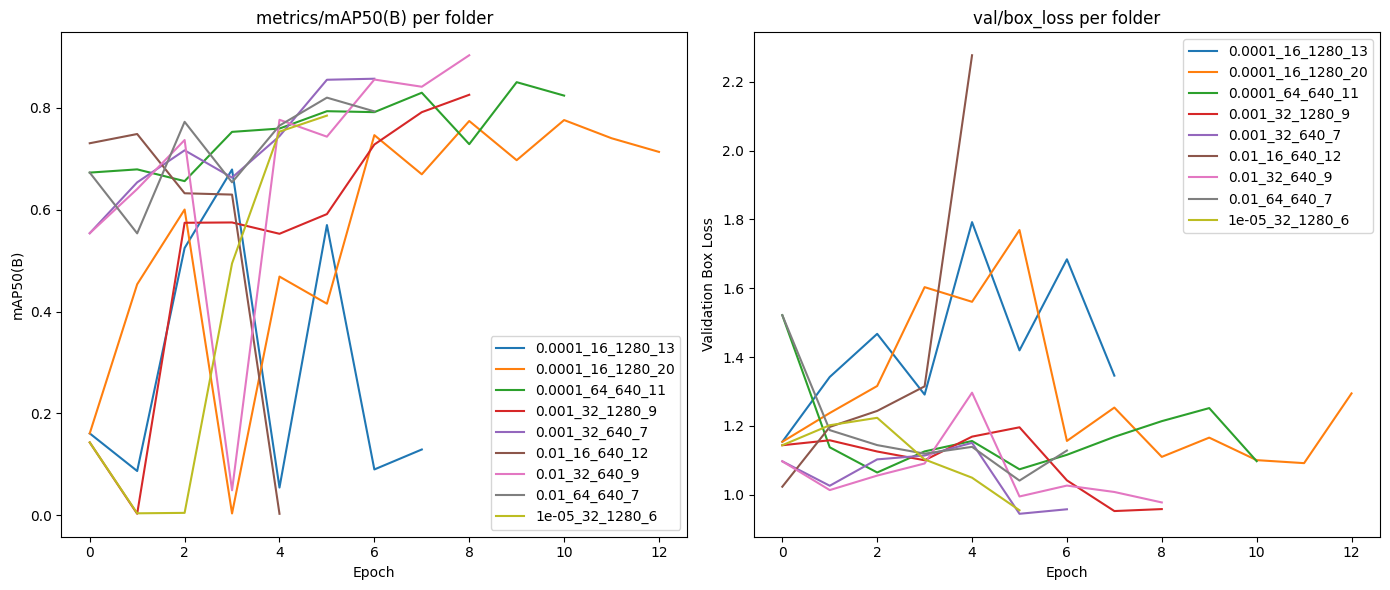

In [12]:
# Plotting
plt.figure(figsize=(14, 6))

# Plot metrics/mAP50(B)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
for i, mAP in enumerate(mAPs):
    plt.plot(mAP, label=folder_names[i])
plt.title('metrics/mAP50(B) per folder')
plt.xlabel('Epoch')
plt.ylabel('mAP50(B)')
plt.legend()

# Plot val/box_loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
for i, loss in enumerate(box_losses):
    plt.plot(loss, label=folder_names[i])
plt.title('val/box_loss per folder')
plt.xlabel('Epoch')
plt.ylabel('Validation Box Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
%matplotlib inline

In [13]:
model = YOLO('/Users/vladandreichuk/Desktop/git_reps/ComputerVision/runs/0.01_32_640_9/weights/best.pt')

In [14]:
# Directory containing new unseen images
testing_images_dir = 'datasets/data/testing_images'

# Generate predictions for the entire directory
results = model.predict(source=testing_images_dir)


image 1/175 /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/testing_images/vid_5_25100.jpg: 384x640 (no detections), 234.0ms
image 2/175 /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/testing_images/vid_5_25120.jpg: 384x640 (no detections), 160.6ms
image 3/175 /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/testing_images/vid_5_25140.jpg: 384x640 (no detections), 176.6ms
image 4/175 /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/testing_images/vid_5_25160.jpg: 384x640 (no detections), 190.5ms
image 5/175 /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/testing_images/vid_5_25180.jpg: 384x640 (no detections), 136.7ms
image 6/175 /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/testing_images/vid_5_25200.jpg: 384x640 (no detections), 140.0ms
image 7/175 /Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/testing_images/vid_5_25220.jpg: 384x640 (no detec

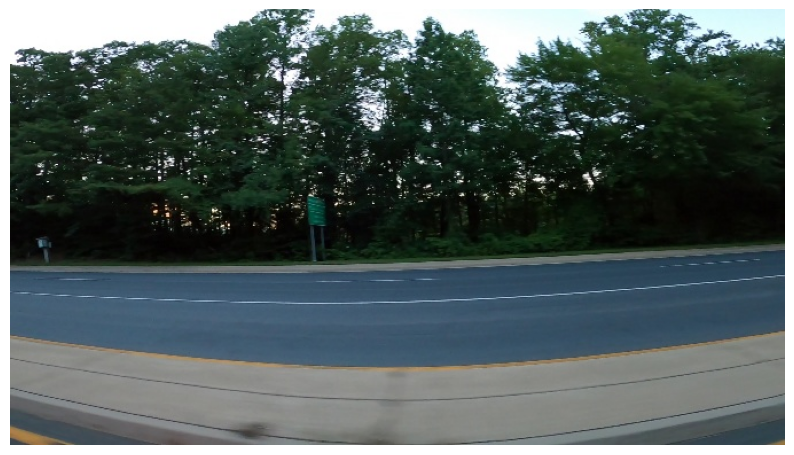

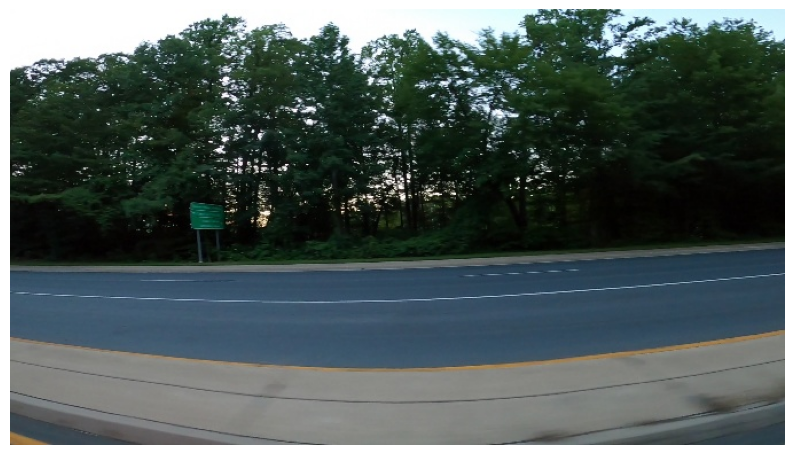

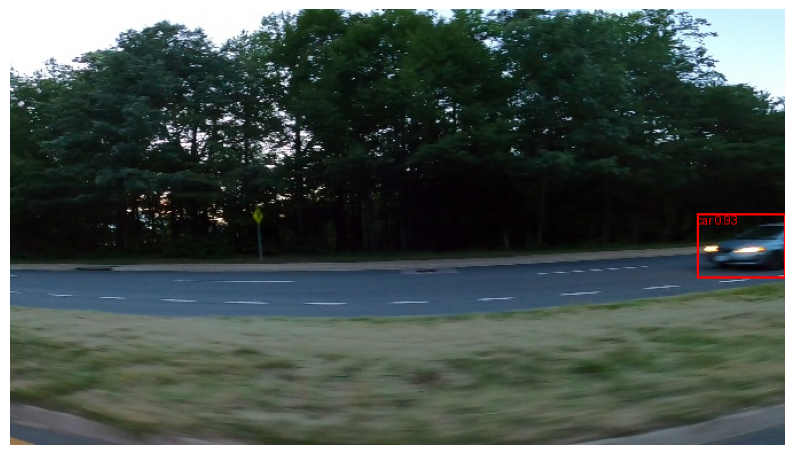

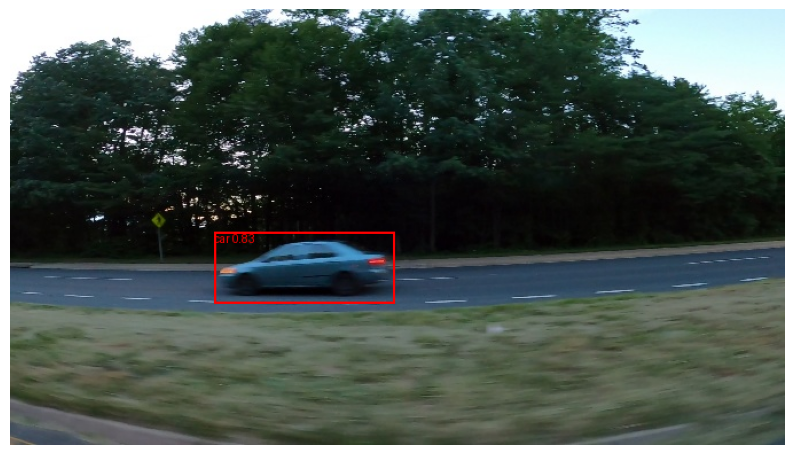

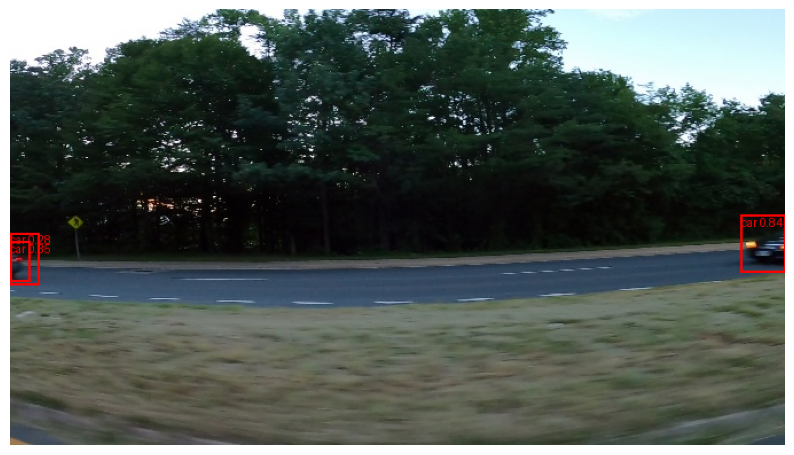

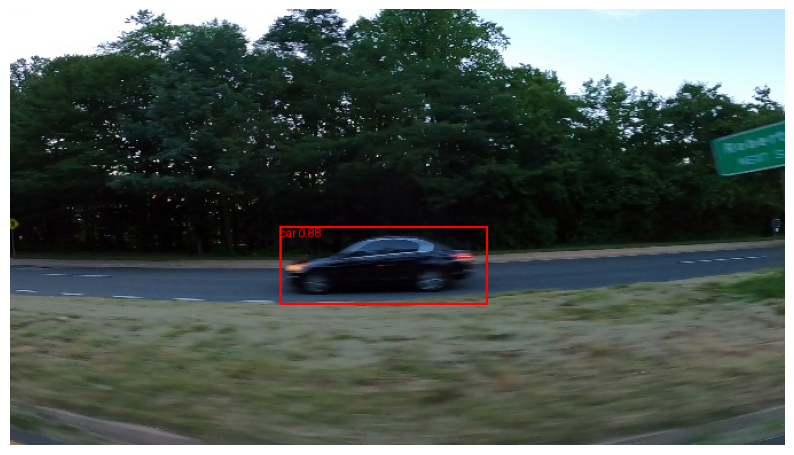

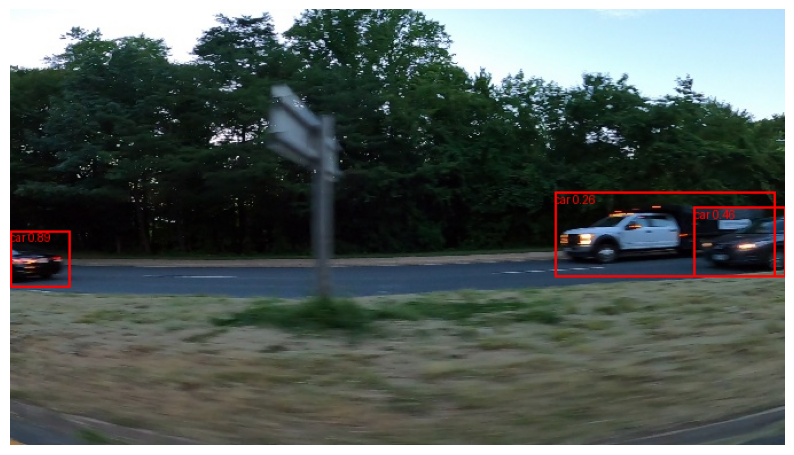

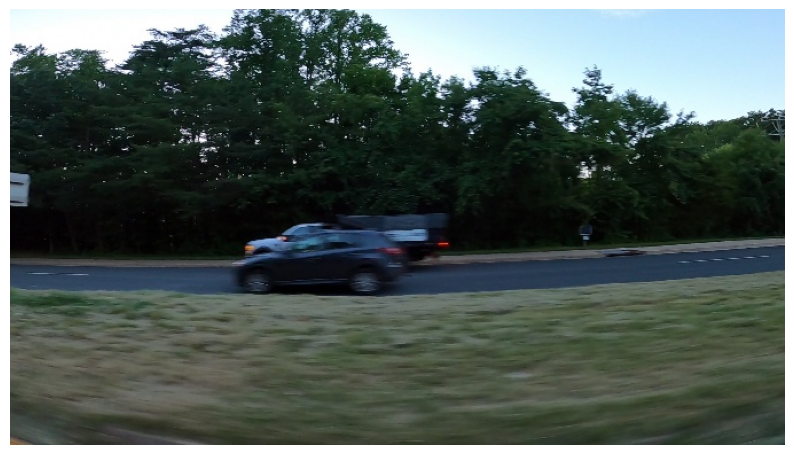

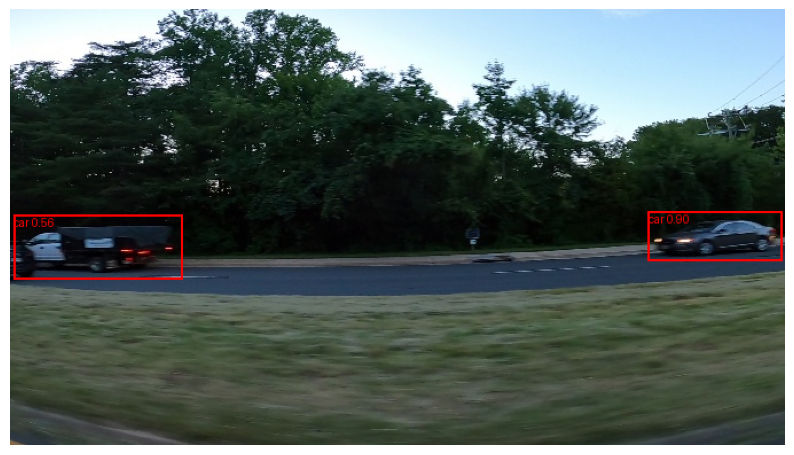

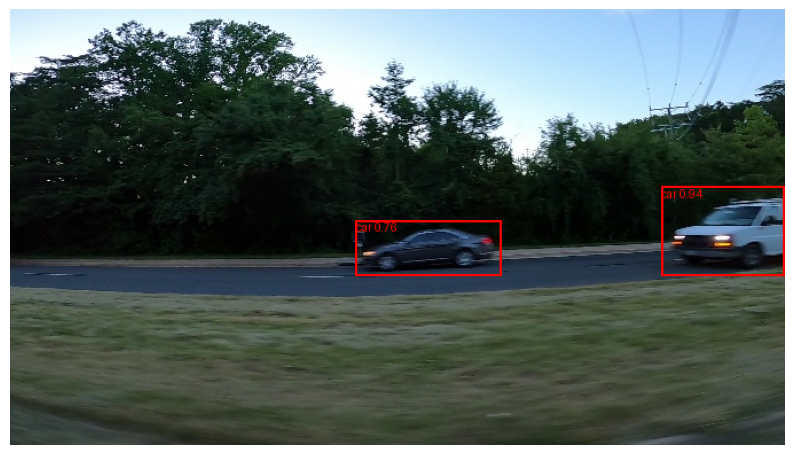

In [15]:
# Function to draw predictions on an image
def draw_predictions(image, boxes, names):
    draw = ImageDraw.Draw(image)
    for i, box in enumerate(boxes.data):  # Iterate over the 'data' attribute of the Boxes object
        # Extract bounding box coordinates and other information
        x_min, y_min, x_max, y_max, conf, cls_id = box
        cls_name = names[int(cls_id)]  # Convert class ID to the corresponding name
        
        # Format the label to include class name and confidence
        label = f"{cls_name} {conf:.2f}"
        
        # Draw the bounding box and label on the image
        draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)
        draw.text((x_min, y_min), label, fill="red")

# Iterate over the results to process and visualize each
for result in results[10:20]:
    # Load the image based on the 'path' attribute of the result
    image = Image.open(result.path).convert("RGB")
    
    # Draw the detections on the image
    draw_predictions(image, result.boxes, model.names)
    
    # Display the image with the drawn detections
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")  # Hide the axis
    plt.show()
